# Predicting Loan Defaults: Data Analysis, Model Development, and Business Insights
---

## Probelem Statement
---

The problem at hand is to develop a predictive model that can accurately determine the likelihood of loan defaults based on the profiles of loan applicants. The lending company faces two main risks when approving loans: rejecting a creditworthy applicant results in lost business, while approving a high-risk applicant may lead to financial loss. The goal is to analyze historical loan application data to identify patterns and relationships between applicant characteristics (such as income, loan amount, interest rate, and credit history) and the likelihood of default. By building a reliable model, the company can make more informed decisions, such as denying loans, adjusting loan terms, or setting higher interest rates for riskier applicants, ultimately improving its financial performance and reducing defaults.

## Business Understanding
---

The business objective of this project is to help the lending company optimize its loan approval process by accurately predicting the likelihood of loan defaults. The company faces a dual challenge: rejecting creditworthy applicants results in missed opportunities for business growth, while approving high-risk applicants exposes the company to significant financial loss. With this in mind, the company needs a data-driven approach to assess applicant risk and make informed decisions. By analyzing historical loan data, including applicant demographics, financial profiles, and loan characteristics, the company can identify key factors that influence default risk. The ultimate goal is to reduce loan defaults, improve profitability, and increase the efficiency of the loan approval process. Moreover, the company can utilize these insights to refine its lending criteria, set appropriate interest rates, and implement more tailored loan terms, ensuring that both business and customer interests are aligned.

### Project objectives
- Conduct a thorough exploratory analysis of the loan application data to identify patterns, trends, and correlations between applicant features and loan default risk.
- Select and compare different machine learning models to predict loan defaults.
- Provide actionable recommendations to the Lending Company based on model insights.
- Develop an API to handle request and respond with predicted loan status of the applicant.

### Metrics Of Success

While specific benchmarks can vary by organization and context, a recall rate of 70-80% is often considered acceptable for high-risk applications like loan default prediction. This ensures that the majority of potential defaulters are identified, reducing financial risk.

Therefore for this project we aim to achieve a recall score of above 70% so that we have a model that meets the industry standards.


## Data Understanding
---
The dataset comprises historical loan application records of 396,030 borrowers, including various features that describe the applicants' profiles and the outcomes of their loan applications. 

Key features include financial attributes (e.g., annual income, total credit revolving balance, debt-to-income ratio, loan amount), demographic information (e.g., age, employment length, home ownership status), and loan characteristics (e.g., interest rate, loan term, loan purpose). 

The target variable is the loan status, which indicates whether the applicant fully paid the loan, is currently repaying (current), or defaulted (charged-off). 
Additionally, the dataset also contain features such as the month the borrower's earliest reported credit line was opened, the number of open credit lines, and public records indicating past delinquencies.


In [2]:
#importing libraries 
import time
import re
import pickle
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score, f1_score, ConfusionMatrixDisplay, roc_auc_score


In [3]:
# expanding the number of visible columns
pd.set_option('display.max_columns', None)

In [4]:
#loading the dataset
df = pd.read_excel('data.xlsx', sheet_name='Loan data')


In [5]:
df.shape

(396030, 27)

In [6]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,2015-01-01,Fully Paid,vacation,Vacation,26.24,1990-06-01,16,0,36369,41.8,25,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,2015-01-01,Fully Paid,debt_consolidation,Debt consolidation,22.05,2004-07-01,17,0,20131,53.3,27,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,2015-01-01,Fully Paid,credit_card,Credit card refinancing,12.79,2007-08-01,13,0,11987,92.2,26,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,2014-11-01,Fully Paid,credit_card,Credit card refinancing,2.60,2006-09-01,6,0,5472,21.5,13,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,2013-04-01,Charged Off,credit_card,Credit Card Refinance,33.95,1999-03-01,13,0,24584,69.8,43,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   loan_amnt             396030 non-null  int64         
 1   term                  396030 non-null  object        
 2   int_rate              396030 non-null  float64       
 3   installment           396030 non-null  float64       
 4   grade                 396030 non-null  object        
 5   sub_grade             396030 non-null  object        
 6   emp_title             373103 non-null  object        
 7   emp_length            377729 non-null  object        
 8   home_ownership        396030 non-null  object        
 9   annual_inc            396030 non-null  float64       
 10  verification_status   396030 non-null  object        
 11  issue_d               396030 non-null  datetime64[ns]
 12  loan_status           396030 non-null  object        
 13 

In [8]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [9]:
#checking the distributin of the `loan_status` feature
df['loan_status'].value_counts(normalize= True)

loan_status
Fully Paid     0.803871
Charged Off    0.196129
Name: proportion, dtype: float64

In [10]:
#checking distribution of bublic record of bankrupties feature
df['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0.0    350380
1.0     42790
2.0      1847
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: count, dtype: int64

In [11]:
#cheking missing values
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1757
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

## EXPLORATORY DATA ANALYSIS

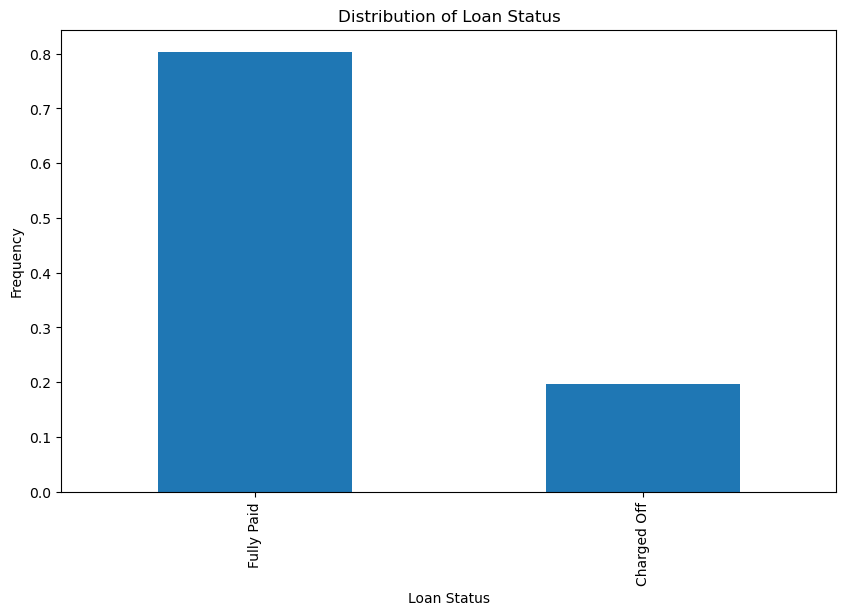

In [12]:
#Distribution of loan status

plt.figure(figsize= (10, 6))

df['loan_status'].value_counts(normalize= True).plot(kind = 'bar')

#labeling the axes
plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Status');

In [13]:
#masking out to have only the positive class

df_default = df[df['loan_status'] == 'Charged Off']

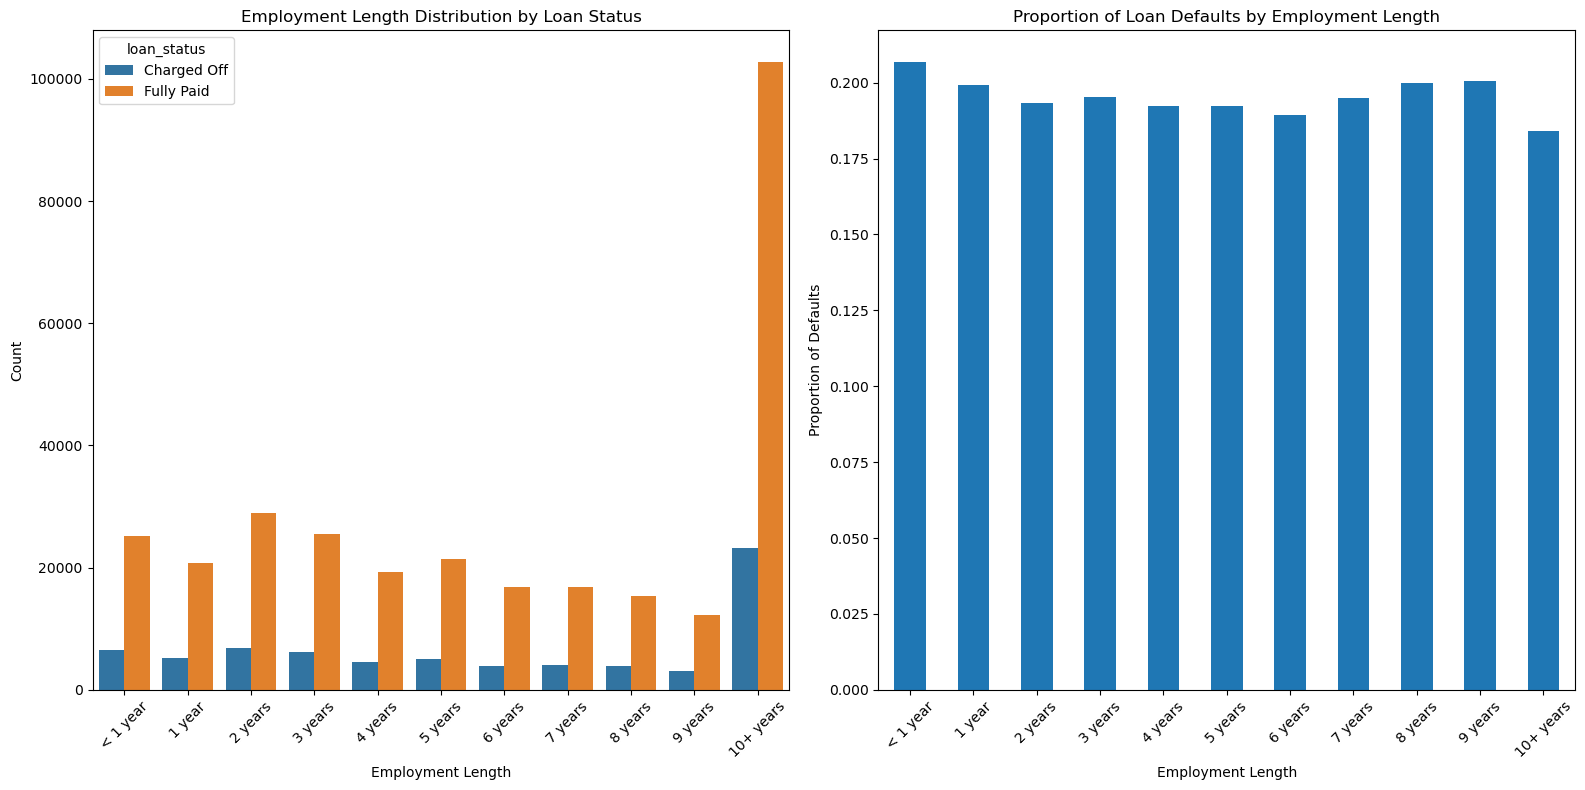

In [14]:
# employment length and loan status

#ordering the years for easie visual interpretation
emp_length_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years',
                        '9 years', '10+ years' ]

# Aggregating the data by emp_length and loan_status
emp_length_loan_status_counts = df.groupby(['emp_length', 'loan_status']).size().reset_index(name='counts')

# Create the bar plot
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)

# Plot for counts by loan status
sns.barplot(x='emp_length', y='counts', hue='loan_status', data=emp_length_loan_status_counts, order=emp_length_order, ax=ax1)
ax1.set_xlabel('Employment Length')
ax1.set_ylabel('Count')
ax1.set_title('Employment Length Distribution by Loan Status')
ax1.tick_params(axis='x', rotation=45)

# Calculate the proportion of defaults for each employment length category
default_proportion = (df_default['emp_length'].value_counts() / df['emp_length'].value_counts()).reindex(emp_length_order)

# Plot the proportion of defaults as a bar chart
default_proportion.plot(kind='bar', ax=ax2)
ax2.set_xlabel('Employment Length')
ax2.set_ylabel('Proportion of Defaults')
ax2.set_title('Proportion of Loan Defaults by Employment Length')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Insights:

- Borrowers with longer employment lengths (e.g., '10+ years') tend to apply for and receive more loans. 

-  Employment length appears to be a factor in loan repayment, with those having longer employment lengths (especially 10+ years) showing a slighltly higher likelihood of fully repaying their loans with appoximately 17% of them defaulting compared to 20% in the other employment lengths.


- The proportion of defaults does not vary dramatically across different employment lengths, suggesting that employment length alone may not be a strong indicator of default risk.

**Grade**

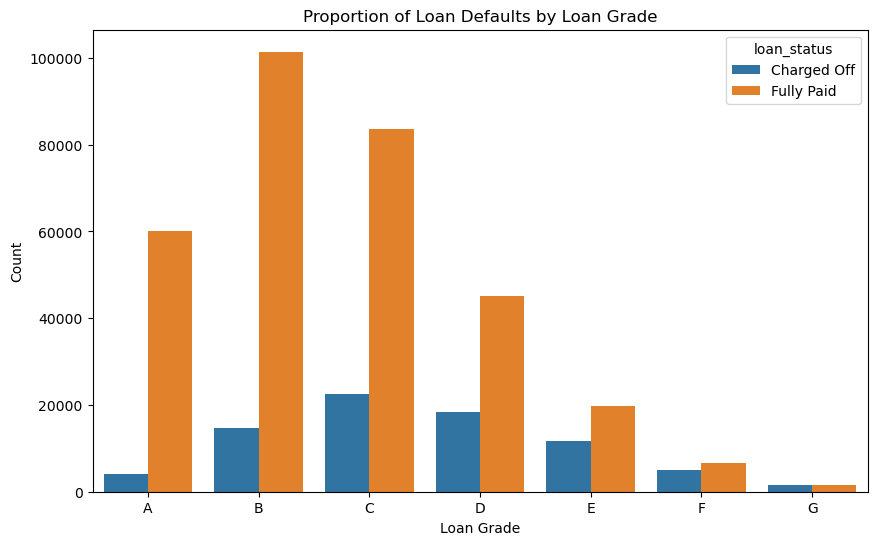

In [15]:
# Aggregating the data by emp_length and loan_status
grade_loan_status_counts = df.groupby(['grade', 'loan_status']).size().reset_index(name='counts')

# Create the bar plot

plt.figure(figsize= (10, 6))
# Plot for counts by loan status
sns.barplot(x='grade', y='counts', hue='loan_status', data= grade_loan_status_counts)

#labeling the axes
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.title('Proportion of Loan Defaults by Loan Grade');

**Insights:**

The letter grades that are assigned to loans indicate the expected risk of the loan

- Loan grades B and C have the highest number of loans, followed by A and D.

- Loan grades F and G have the lowest number of loans, indicating fewer loans are given to riskier grades.

- Loan grades D, E, and F show a relatively higher proportion of charged-off loans compared to grades A, B, and C with grade G having almost 50% rate of default.

**Portfolio Strategy**

- A diversified loan portfolio with a higher proportion of loans in safer grades (A to C) can help manage overall risk while still offering opportunities to higher-risk borrowers with appropriate safeguards.


**Purpose**

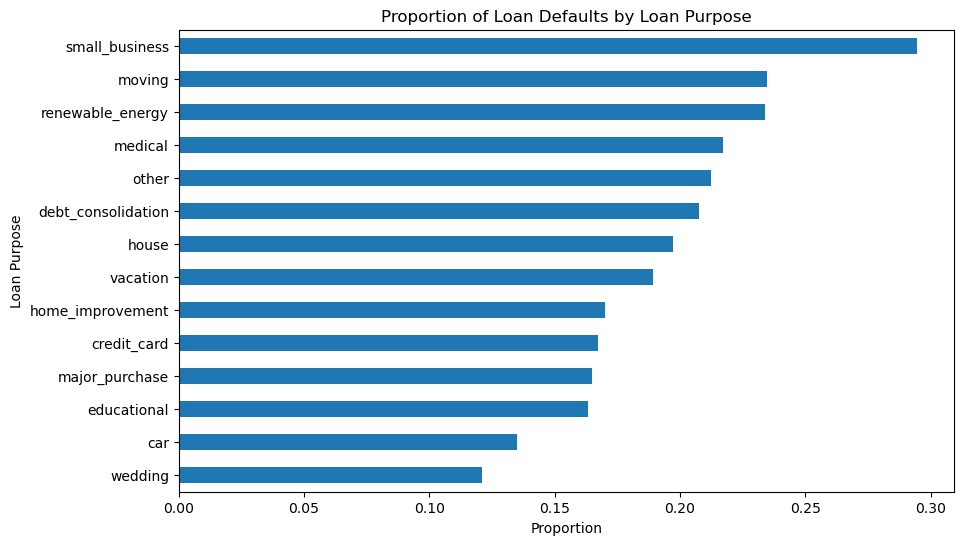

In [16]:
#calculating the default proportion by each grade
default_proportion = (df_default['purpose'].value_counts() / df['purpose'].value_counts()).sort_values()

#ploting the proportions
plt.figure(figsize=(10,6))
default_proportion.plot(kind = 'barh')

#labeling the axes
plt.xlabel('Proportion')
plt.ylabel('Loan Purpose')
plt.title('Proportion of Loan Defaults by Loan Purpose');

**Insights**

- Loan application towards Small Business have significantly higher proportion of defaults with aproximately 30%. 
    - Small businesses often face higher financial instability and market risks compared to established businesses. Many small businesses struggle with cash flow issues, competition, and economic fluctuations, this could explain the the higher proportions of defaults.
    - The club could consider implementing more rigorous credit assessments and due diligence processes for small business loan applicants. Evaluate the business model, financial health, market conditions, and the entrepreneur's experience.
    - Also the club could provide additional support and resources for small business borrowers, such as financial planning, business mentoring, and periodic financial monitoring, to help them succeed and repay their loans.

-  Car and wedding loans have significantly lower proportions of defaults with less that 15% defaulting.
     - Cars are often essential for daily commuting and personal use, making borrowers more likely to prioritize and make timely repayments to avoid losing their vehicle.
     
     - The secured nature of car loans, where the vehicle serves as collateral, further incentivizes timely repayment to avoid repossession, leading to lower default rates.

     - Also wedding loans are often taken for a once-in-a-lifetime event, and borrowers are typically motivated to repay these loans to avoid financial issues during a significant personal milestone.

     - The club should continue to offer these loans as they have lower default rates, contributing to a stable and profitable loan portfolio. 

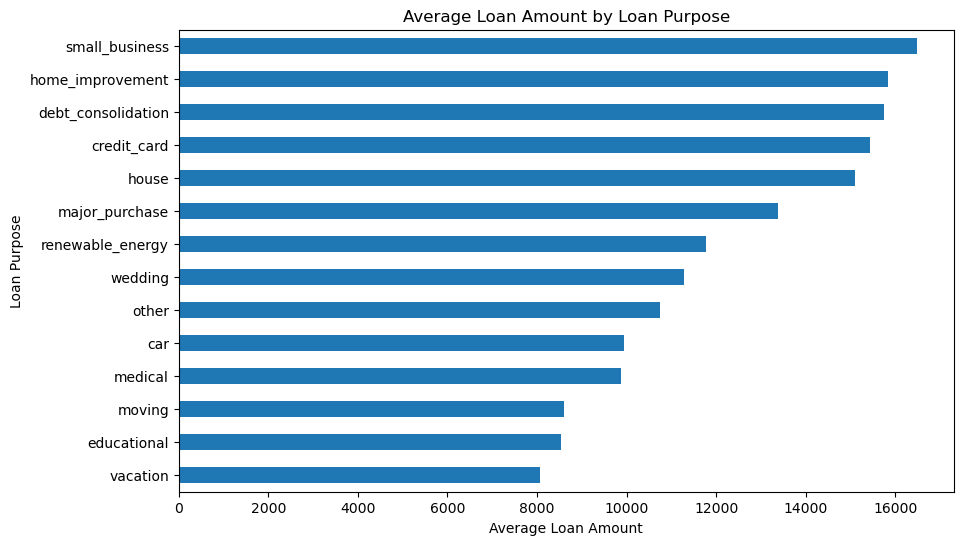

In [17]:
#plotting the distribution of average loan amount by purpose
plt.figure(figsize=(10,6))

df_default.groupby(['purpose'])['loan_amnt'].mean().sort_values().plot(kind= 'barh')

#labeling the axes
plt.xlabel('Average Loan Amount')
plt.ylabel('Loan Purpose')
plt.title('Average Loan Amount by Loan Purpose');

**Insights**

- Given the higher defaults in small business loans as we noticed earlier, the above plot explains this. The loan amounts given towards small business is considerably higher compared to other categories which impose significant repayment burdens on borrowers. 

- Also given the intense competition in the market and susceptibility to economic fluctuations, small businesses face substantial pressure, often resulting in financial instability and higher default rates.

- Also we notice car loans are significantly smaller loan amounts compared to business loans, making them more manageable for borrowers to repay.



In [18]:
#Setting pandas display options to show more decimal places and avoid scientific notation
pd.set_option('display.float_format', lambda x: f"{x:.2f}")

In [19]:
#checking descriptive statistics  for the numeric features
df.select_dtypes('number').describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,395754.00,396030.00,358235.00,395495.00
mean,14113.89,13.64,431.85,74203.18,17.38,11.31,0.18,15844.54,53.79,25.41,1.81,0.12
std,8357.44,4.47,250.73,61637.62,18.02,5.14,0.53,20591.84,24.45,11.89,2.15,0.36
min,500.00,5.32,16.08,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
25%,8000.00,10.49,250.33,45000.00,11.28,8.00,0.00,6025.00,35.80,17.00,0.00,0.00
50%,12000.00,13.33,375.43,64000.00,16.91,10.00,0.00,11181.00,54.80,24.00,1.00,0.00
75%,20000.00,16.49,567.30,90000.00,22.98,14.00,0.00,19620.00,72.90,32.00,3.00,0.00
max,40000.00,30.99,1533.81,8706582.00,9999.00,90.00,86.00,1743266.00,892.30,151.00,34.00,8.00


In [20]:
# Calculate the correlation matrix for the default class
corr_matrix = df_default.select_dtypes('number').corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask)

# Apply background gradient
corr_matrix.style.background_gradient(axis=None)


,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
int_rate,0.239662,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
installment,0.944914,0.232592,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
annual_inc,0.346057,-0.004488,0.337845,nan,nan,nan,nan,nan,nan,nan,nan,nan
dti,-0.001544,0.025685,-0.002702,-0.039229,nan,nan,nan,nan,nan,nan,nan,nan
open_acc,0.197836,0.026271,0.185941,0.138521,0.064753,nan,nan,nan,nan,nan,nan,nan
pub_rec,-0.052198,0.016470,-0.041496,0.006561,-0.007823,-0.005721,nan,nan,nan,nan,nan,nan
revol_bal,0.321166,-0.001901,0.300818,0.260673,0.034821,0.243707,-0.090472,nan,nan,nan,nan,nan
revol_util,0.081180,0.184093,0.097849,0.037808,0.034082,-0.129294,-0.088642,0.243200,nan,nan,nan,nan
total_acc,0.247826,-0.004180,0.221157,0.182538,0.052344,0.687056,0.020760,0.213957,-0.096456,nan,nan,nan


In [21]:
# Calculate the correlation matrix for all the borowers
corr_matrix = df.select_dtypes('number').corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask)

# Apply background gradient
corr_matrix.style.background_gradient(axis=None)


,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
int_rate,0.168921,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
installment,0.953929,0.162758,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
annual_inc,0.336887,-0.056771,0.330381,nan,nan,nan,nan,nan,nan,nan,nan,nan
dti,0.016636,0.079038,0.015786,-0.081685,nan,nan,nan,nan,nan,nan,nan,nan
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,nan,nan,nan,nan,nan,nan,nan
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,nan,nan,nan,nan,nan,nan
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,nan,nan,nan,nan,nan
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,nan,nan,nan,nan
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,nan,nan,nan


**Insights**

- Installment is highly positively correlated with Loan Amount, 0.95, which makes sense, as larger loans require larger monthly payments.

- Installment also has a moderate positive correlation with Annual Income 0.33, indicating that borrowers with higher incomes tend to have higher monthly installments.

- Debt-to-Income Ratio (`dti`) has a very weak correlation with other financial factors, indicating that the ratio of debt to income doesn’t strongly correlate with the loan amount, installment, or annual income.

- Open Accounts (`open_acc`) has a strong positive correlation with Total Accounts (`total_acc`), 0.68, which makes sense as both variables represent the number of accounts a borrower has.

- Public Records (`pub_rec`) has a moderate positive correlation with Bankruptcies (`pub_rec_bankruptcies`), 0.7, indicating that borrowers with number of derogatory public records are more likely to have a bankruptcy record as well.

- There is no notable significant difference in the correlations between the Charged off class and all the borrowers



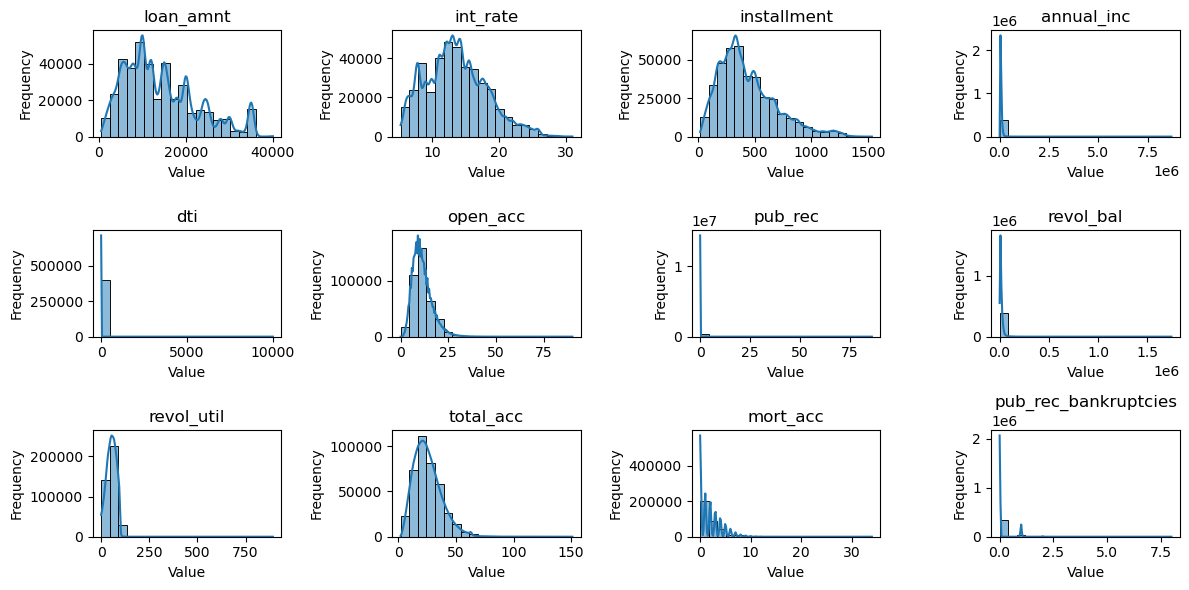

In [22]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12, 6))

for i, col in enumerate(df.select_dtypes('number').columns):
    ax = axs[i // 4, i % 4]
    sns.histplot(df[col], bins=20, kde=True, ax=ax)  # Use sns.histplot() for kde
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Insights**

- `loan_amnt`: The distribution of loan amounts is right-skewed, with most loans concentrated between $5,000 and $15,000, and fewer loans at higher amounts up to $40,000.

- `int_rate`: The interest rates are roughly normally distributed, with a peak around 10% to 15%. The distribution tails off towards higher interest rates, going up to around 30%.

- `installment`: Installment amounts also show a right-skewed distribution similar to loan amounts, with most installments between $200 and $500 per month.

- `annual_inc`: Annual income has a highly right-skewed distribution with a long tail, indicating a wide range of incomes. The majority of borrowers have incomes below $200,000, with a few earning significantly higher amounts.

- `dti`: Debt-to-income ratio (DTI) is highly right-skewed, with most values below 50. There are some extreme values indicating higher DTI ratios.

- `open_acc`: The number of open credit lines follows a slightly right-skewed distribution, with most borrowers having between 5 and 20 open accounts.

- `pub_rec`: The number of derogatory public records is heavily right-skewed, with most borrowers having no public records and a small number having up to 5.

- `revol_bal`: Revolving credit balance is highly right-skewed, with most values clustered below $50,000. There are a few borrowers with much higher revolving balances.

- `revol_util`: The utilization rate of revolving credit is right-skewed, with most values between 0% and 100%, and some extreme values going up to around 150%.

- `total_acc`: The total number of credit lines ever opened is slightly right-skewed, with most borrowers having between 10 and 40 total accounts.

- `mort_acc`: The number of mortgage accounts is heavily right-skewed, with most borrowers having none or one mortgage account, and very few having more than 5.

- `pub_rec_bankruptcies`: The number of public record bankruptcies is heavily right-skewed, with most borrowers having no bankruptcies on record, and very few having up to 2.

**ANNUAL INCOME**

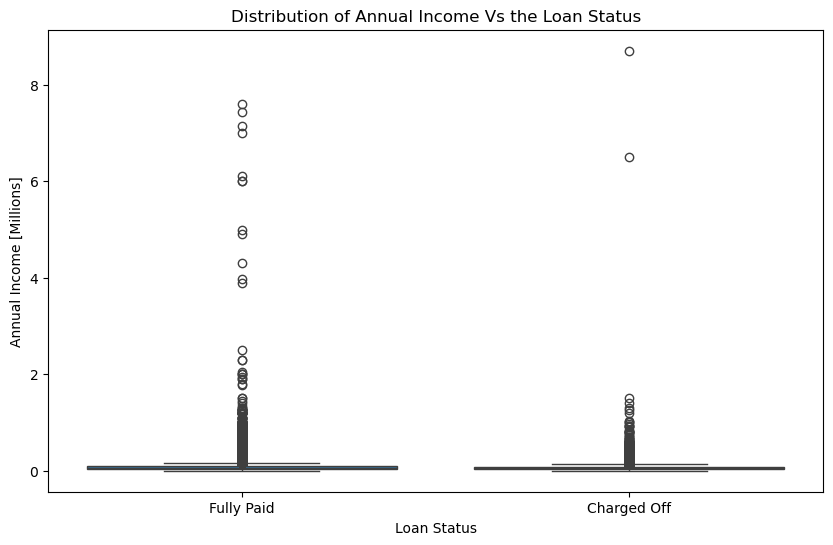

In [23]:
#plotting distribution of income vs loan status
plt.figure(figsize= (10,6))
sns.boxplot(y = df['annual_inc']/1e6, x = df['loan_status'])

#labeling axes
plt.xlabel('Loan Status')
plt.ylabel('Annual Income [Millions]')
plt.title('Distribution of Annual Income Vs the Loan Status');

**Insights**

- The IQR for both groups is similar, indicating that the middle 50% of borrowers have similar income ranges regardless of loan status.

- There are a significant number of outliers in both groups, with several borrowers reporting extremely high annual incomes (up to $8 million).

- Generally the majority of borrowers in both categories have annual incomes clustered around lower values, with a long tail extending towards higher incomes. This is consistent with the earlier observation of a right-skewed distribution of annual income in the dataset.

-  This indicates that while income is an important factor, it should be considered alongside other variables when assessing credit risk and predicting loan outcomes.

**The total number of credit lines (`total_acc`)**

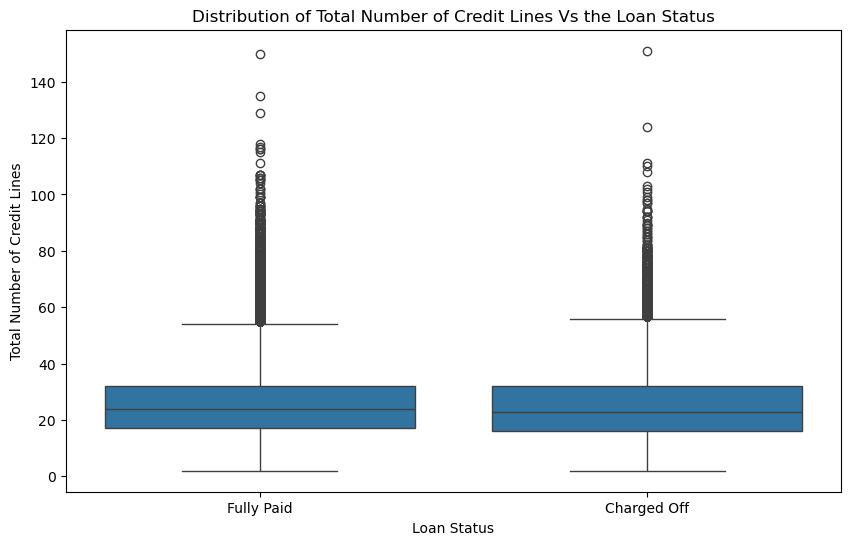

In [24]:
plt.figure(figsize= (10,6))
sns.boxplot(y = df['total_acc'], x = df['loan_status'])

plt.xlabel('Loan Status')
plt.ylabel('Total Number of Credit Lines')
plt.title('Distribution of Total Number of Credit Lines Vs the Loan Status');

**Insights**

- The median number of credit lines is similar for both "Fully Paid" and "Charged Off" loans, approximately around 25 credit lines.
- There are slightly more extreme outliers in the "Fully Paid" category compared to the "Charged Off" category.
- The distribution of credit lines appears to be slightly more spread out for "Fully Paid" loans, as indicated by the wider whiskers.
  
*Interpretation*

- The total number of credit lines does not show a strong difference between those who fully paid their loans and those who defaulted. The similar median and IQR values suggest that the number of credit lines might not be a strong predictor of loan default. However, the presence of numerous outliers indicates that there are individuals with an unusually high number of credit lines in both groups, which could be worth further investigation. This analysis suggests that other factors, beyond just the number of credit lines, should be considered to effectively predict loan defaults.



**Interest Rate on the loan(`int_rate`)**

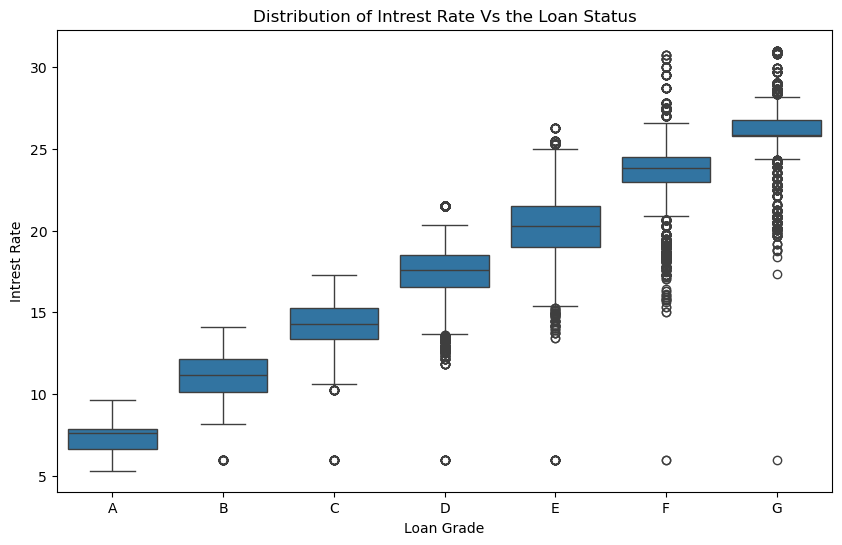

In [25]:
#Plotting intrest rates against loan grades
plt.figure(figsize= (10,6))
sns.boxplot(y = df['int_rate'], x = df['grade'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])

plt.xlabel('Loan Grade')
plt.ylabel('Intrest Rate')
plt.title('Distribution of Intrest Rate Vs the Loan Status');

**Insights**

- There is a significant difference in the interest rates charged across different loan grades, with higher risk borrowers incurring substantially higher interest rates. This aligns with the lending industry's standard practice of risk-based pricing, where interest rates are adjusted based on the borrower's creditworthiness.

- The median interest rate for grade A borrowers, who are considered low risk, is approximately 7.5%. In contrast, high-risk borrowers in grade G are charged a median interest rate of around 25%. This wide disparity reflects the increased risk of default associated with lower credit grades, necessitating higher interest rates to compensate for potential losses.

- The previous analysis revealed that the default rate among grade G borrowers is alarmingly high, nearing 50%. This high default rate justifies the elevated interest rates charged to these borrowers, as lenders need to offset the increased likelihood of loan defaults through higher returns on the loans that do get repaid.

**SUB GRADE**

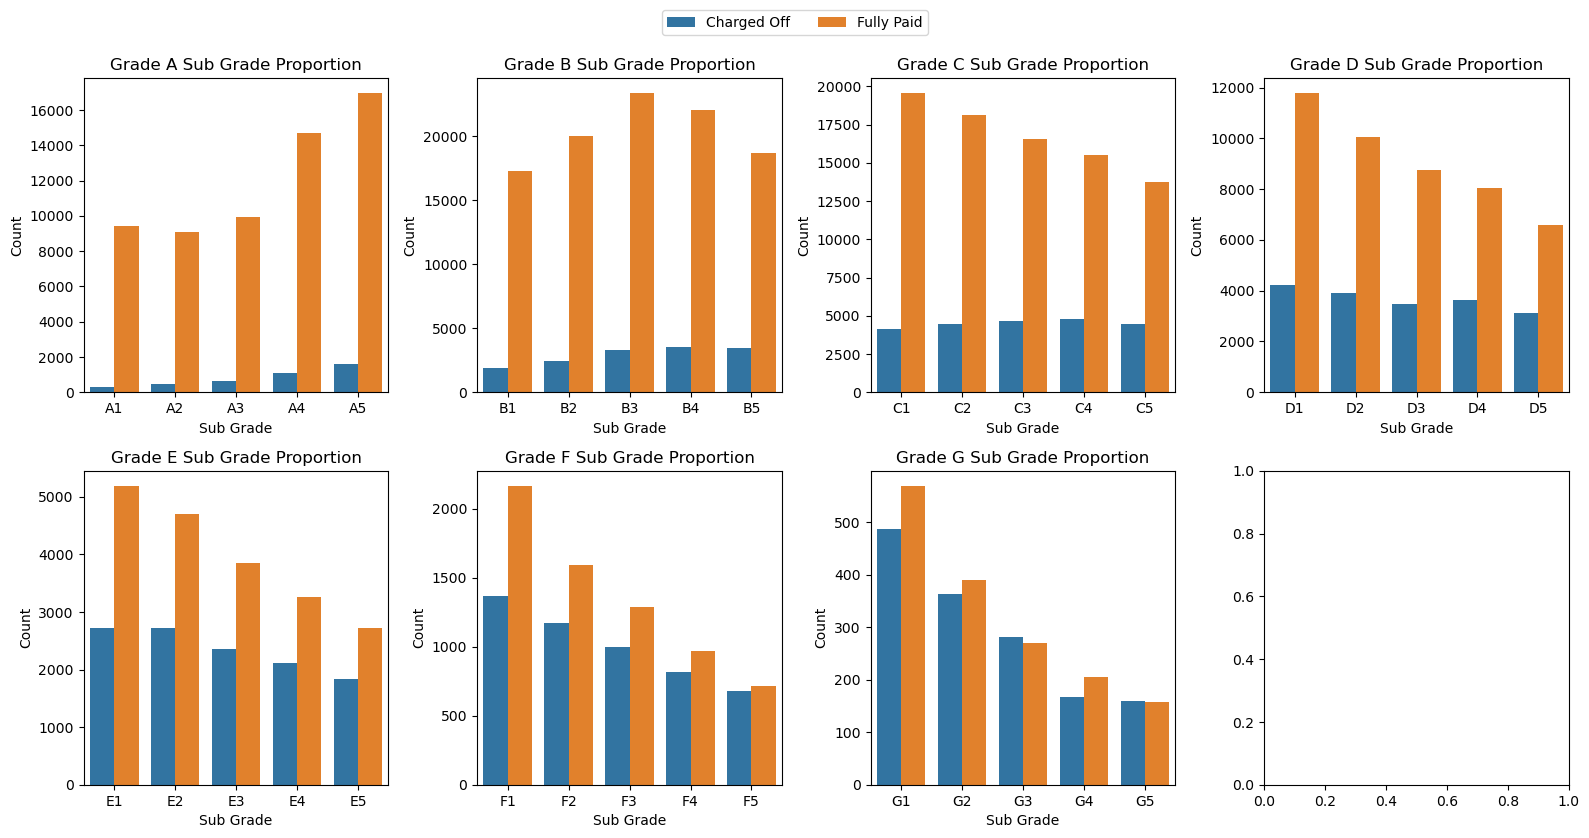

In [26]:
# listing the all the grades

grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

#plottting proportion of subgrade for loan status for each subgrade.
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(16, 8))

for i, grade in enumerate(grades):
    mask = df['grade'] == grade
    df_mask = df[mask]
    sub_loan_status_counts = df_mask.groupby(['sub_grade', 'loan_status']).size().reset_index(name='counts')

    ax = axs[i // 4, i % 4]
    
    sns.barplot(x='sub_grade', y='counts', hue='loan_status', data=sub_loan_status_counts, ax=ax)
    
    # Removing the individual legend
    ax.legend_.remove()

    # Labeling the axes
    ax.set_title(f'Grade {grade} Sub Grade Proportion')
    ax.set_ylabel('Count')
    ax.set_xlabel('Sub Grade')

# Creating a single legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

**Insights**

-  Within each grade, sub-grades generally follow the same trend, with "Fully Paid" loans outnumbering "Charged Off" loans, but the gap narrows significantly in higher-risk grades (E, F, G).

**EMPLOYMENT TITLES**

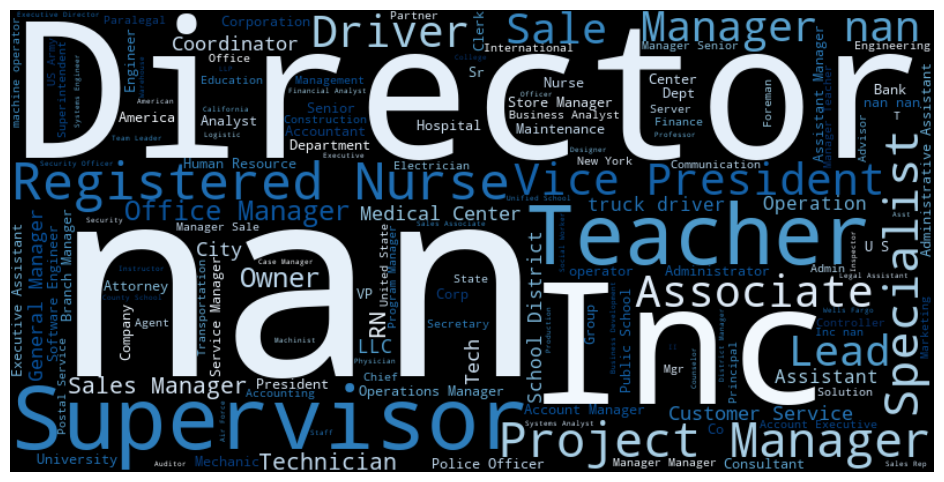

In [27]:
all_titles = ' '.join(df['emp_title'].astype(str))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black',
                       width=800, height=400, max_words=150, random_state=42, colormap = 'Blues').generate(all_titles)
# Display the generated image
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=1, y=1)
plt.show()

**Insights**

- The most common job titles for borrowers are "Director," "Supervisor," "Manager," "Registered Nurse," "Teacher," "Project Manager," and "Driver."

-  The term "nan" is also prominently featured, suggesting a significant number of missing or undefined employment titles in the dataset. We shall expolore this to handle this during the cleaning.


## DATA CLEANING

In [28]:
#defing a function to check for missing values
def missing_data(df):
    missing_data = df.isna().sum()
    missing_data = missing_data[missing_data>0]
    return missing_data.to_frame()

In [29]:
#checking missing data in every column
missing_data(df).T

,emp_title,emp_length,title,revol_util,mort_acc,pub_rec_bankruptcies
0,22927,18301,1757,276,37795,535


**Exploring Emloyment Title Feature**

Given the huge amount of data of applicants with missing employment title, we cannot afford to lose such data because they also important to our analysis that is they may be a group of people making entry into employment, maybe even transitioning careers or did not feel comfortable disclosing their employment titles. Therefore instead of dropping them for this project, I will replace them with `"Undisclosed"`.

In [30]:
#replacing the missing values with `undisclosed`

df['emp_title'] = df['emp_title'].replace('', 'Undisclosed').fillna('Undisclosed')

In [31]:
#convert the titles to lowercase
df['emp_title'] = df['emp_title'].str.lower()

In [32]:
#exploring `emp_title`
print(f"Number of unique employment titles: {df['emp_title'].nunique()}")

Number of unique employment titles: 154000


Given the high cardinality of this feature, below I will explore more about this feature to gain more insights before deciding on what how to solve the high cardinality thereafter deal with the missing values

In [33]:
#sampling a few titles
df['emp_title'].value_counts().head()

emp_title
undisclosed         22929
manager              5637
teacher              5430
registered nurse     2627
supervisor           2591
Name: count, dtype: int64

When you check at these titles closely, you notice that some of the titles are just the same however some aplicants chose to write their titles in full while others chose to use short forms of their titles.

Therefore in this project in an attempt we shall clean these titles to combines titles that are similar.

The title `rn` is mostly used when refering to `registered nurses` in the US since the addresses of most of the applicants in this dataset are in the US.
therefore in this project I will replace `rn` with `registered nurse`.

Also noticed there were different designations in the nursing field like, `field nurse`, `field nurse` and so on. In this project, we shall replace any accurance of nurse with `registered nurse`.


In [34]:
# Define the replacement function for nurse
patterns = [
    r'\bnurse\b',
    r'\brn\b'
]

def replace_nurse(title):
    if pd.isna(title):  # Check for NaN values
        return title
    for pat in patterns:
        # Check if the title contains 'nurse' or 'rn' (case-insensitive)
        if re.search(pat, title, flags=re.IGNORECASE):
            return 'registered nurse'
    return title

# Fill NaN values with 'Undisclosed' to handle them
df['emp_title'] = df['emp_title'].fillna('Undisclosed')

# Apply the replacement function
df['emp_title'] = df['emp_title'].apply(replace_nurse)


In [35]:
#sanity check
df['emp_title'][df['emp_title'].str.contains(r'\bnurse\b', regex = True)].sample(5)

27401     registered nurse
378249    registered nurse
111588    registered nurse
370526    registered nurse
305023    registered nurse
Name: emp_title, dtype: object

I also noticed there were different kinds of engineers, from mechanical engineers to technical engineers, to reduce the cardinality in this feature, we shall refer to all different engineers as `engineer`.

In [36]:
#defining case replacement function for engineer
def replace_engineer(title):
    # Check if the title contains 'engineer' (case-insensitive)
    if re.search(r'\bengineer\b', title, flags=re.IGNORECASE):
        return 'engineer'
    return title

# Apply the replacement function
df['emp_title'] = df['emp_title'].apply(replace_engineer)

In [37]:
#sanity check
df['emp_title'][df['emp_title'].str.contains(r'\bengineer\b', regex = True)].sample(5)

206855    engineer
209927    engineer
6804      engineer
147138    engineer
224596    engineer
Name: emp_title, dtype: object

Also for police, we notice there are different titles of police officers i.e `military police`, `police lieutenant`, `police detective`, `sergeant` et al. therefore for this project, I shall generalize all proffessional within police department as `police officer`.

In [38]:
#defining case replacement function for police
patterns = [
    r'\bpolice\b',
    r'\bsergeant\b'
]

def replace_police(title):
    # Check if the title contains 'police' (case-insensitive)
    for pat in patterns:
        if re.search(pat, title, flags=re.IGNORECASE):
            return 'police officer'
    return title

# Apply the replacement function
df['emp_title'] = df['emp_title'].apply(replace_police)

Also generally, I applicants we into consululting provided more specific to the areas they were consulting on for example we have `metrics consultant`, `senior consultant, marketing`, `sales consultant`. For this project i shall group all consultants as one and refer to each every one of them just as `consultant`.

In [39]:
#defining case replacement function for consultant
def replace_consultant(title):
    # Check if the title contains 'consultant' (case-insensitive)
    if re.search(r'\bconsultant\b', title, flags=re.IGNORECASE):
        return 'consultant'
    return title

# Apply the replacement function
df['emp_title'] = df['emp_title'].apply(replace_consultant)

In [40]:
#sanity check
df['emp_title'][df['emp_title'].str.contains(r'\bconsultant\b', regex = True)].sample(10)

153245    consultant
365170    consultant
31248     consultant
239070    consultant
223561    consultant
329796    consultant
94146     consultant
212227    consultant
93726     consultant
89642     consultant
Name: emp_title, dtype: object

Also for Vice president title, some applicants chose to go with `vp` instead of vice president. Also went ahead to be specific on role assigned i.e `vp-risk manager`, ` vp, business development`, `Senior Vice President` etc, therefore for this project I will generalize all vice presidents as `vice president` regardless of the specialization of vp.

In [41]:
# Defining the pattern to identify Vice President (VP) titles
vp_patterns = [
    r'\bvice president\b',               # "Vice President"
    r'\bvp\b',                            # "VP"
    r'\bsenior\s*vice president\b',       # "Senior Vice President"
    r'\bexecutive\s*vice president\b',    # "Executive Vice President"
    r'\bvp\s*(?:of\s*\w+)?\b',            # "VP" followed by optional "of <department>"
]

# Define the function to check if title matches any VP pattern
def replace_vp(title):
    for pat in vp_patterns:
        if re.search(pat, title, flags=re.IGNORECASE):
            return 'vice president'
    return title

# Apply the function to replace VP titles
df['emp_title'] = df['emp_title'].apply(replace_vp)

There are cases where applicants used `admin assistant`, `office administrator`,`administrative assistant`, `receptionist`, `office manager`, `executive assistant`, `administrative specialist`, `office assistant`, `office coordinator` as employement title in their loan aplication.

However, all of these titles represent positions primarily focused on supporting office operations, managing administrative tasks, and providing assistance to ensure smooth business functioning. Despite the different titles, the underlying job functions overlap significantly, with the primary focus being on administrative support. Therefore for this project, i will replace them with `administrative assistant`.

In [42]:
patterns = [
    r'\boffice coordinator\b',
    r'\badmin assistant\b',
    r'\boffice administrator\b',
    r'\badministrative assistant\b',
    r'\breceptionist\b',
    r'\boffice manager\b',
    r'\bexecutive assistant\b',
    r'\badministrative specialist\b',
    r'\boffice assistant\b',
]
#define a function to match the pattern then return `administrative assistant` else return original title
def replace_admin(title):
    for pat in patterns:
        if re.search(pat, title, flags=re.IGNORECASE):
            return 'administrative assistant'
    return title

# Apply the function to replace titles
df['emp_title'] = df['emp_title'].apply(replace_admin)

I will also generalize all drivers as one category because some went to be specific as mentioning if they are truck drivers, cab drivers et al.

In [43]:
#defining a fuction to replace the drivers
def replace_driver(title):
    # Check if the title contains 'consultant' (case-insensitive)
    if re.search(r'\bdriver\b', title, flags=re.IGNORECASE):
        return 'driver'
    return title

# Apply the replacement function
df['emp_title'] = df['emp_title'].apply(replace_driver)

In [44]:
#sanity check
df['emp_title'][df['emp_title'].str.contains(r'\bdriver\b', regex = True)].sample(10)

201747    driver
281932    driver
238248    driver
215896    driver
326864    driver
9185      driver
282063    driver
175075    driver
18084     driver
227757    driver
Name: emp_title, dtype: object

In [45]:
# Define the general replace function
def replace_(title, pat, repl_):
    # Check if the title contains pattern (case-insensitive)
    if re.search(pat, title, flags=re.IGNORECASE):
        return repl_
    return title

For teachers,there were cases where we had teachers who specified if they are `maths teacher`, `english teacher` etc. To reduce the cardinality of this feature we shall combine teachers to one category. This will also help to curb the potential issues of over fitting during our modeling.

In [46]:
# treat all teachers as one category
df['emp_title'] = df['emp_title'].apply(replace_, pat=r'\bteacher\b', repl_='teacher')

In [47]:
#sanity check
df['emp_title'][df['emp_title'].str.contains(r'\bteacher\b', regex = True)].sample(10)

357898    teacher
127030    teacher
201197    teacher
345       teacher
237660    teacher
133030    teacher
396017    teacher
295525    teacher
273393    teacher
359202    teacher
Name: emp_title, dtype: object

Given the number of obeservation in this dataset, I made a decicion to categorize employement titles with less than 100 observation as `'others'`.
This is to manage the high cardinality of the feature, simplifying the dataset and ensuring that the model can focus on patterns that are more statistically significant.

Also I made this decision to reduce the computational complexity and and enhance processing efficiency thereby facilitating smoother and faster model training and evaluation.

In [48]:
# Identifying categories with less than 100 counts
categories_to_replace = df['emp_title'].value_counts()[df['emp_title'].value_counts().values < 100].index


# Replacing categories with fewer than 100 occurrences with 'others'
df['emp_title'] = df['emp_title'].apply(lambda x: 'others' if x in categories_to_replace else x)

**Number of mortgage accounts(`mort_acc`)**

From the histogram plots in our analysis, we observed that the distribution of this feature is highly skewed. Imputing missing values with the mean is not ideal in this case, as the mean is sensitive to extreme values and outliers, which can distort the central tendency in skewed distributions.

Instead, we will impute the missing values using the median, as it is a more robust measure of central tendency in the presence of skewness. The median is less affected by outliers and provides a better representation of the typical number of mortgage accounts.

In [49]:
#imputing the missing values with median

df['mort_acc'] = df['mort_acc'].fillna(df['mort_acc'].median())

**Title**

In [50]:
#checking the classes in the `title` feature
df['title'].value_counts().head(12)

title
Debt consolidation         152472
Credit card refinancing     51487
Home improvement            15264
Other                       12930
Debt Consolidation          11608
Major purchase               4769
Consolidation                3852
debt consolidation           3547
Business                     2949
Debt Consolidation Loan      2864
Medical expenses             2742
Car financing                2139
Name: count, dtype: int64

We observe that the feature **`title`** is primarily providing information related to the purpose of the loan, which is already captured by the feature **`purpose`**. The `purpose` feature has much lower cardinality compared to **`title`**, which contains 48,796 unique categories. 

To avoid issues of multicollinearity and reduce the risk of overfitting in our models, we will drop the **`title`** feature. This will streamline the model and prevent redundancy, as the `purpose` feature already conveys the necessary information with greater interpretability and lower complexity.

In [51]:
#dropping the `title` column

df.drop(columns= 'title', inplace= True)

In [52]:
#exploring the borowers with missing employment length
df.loc[pd.isna(df['emp_length'])].sample(5)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
229629,3000,36 months,13.49,101.80,C,C2,undisclosed,NaN,MORTGAGE,27000.00,Not Verified,2016-08-01,Fully Paid,credit_card,23.78,1997-12-01,8,0,6364,33.30,26,w,INDIVIDUAL,5.00,0.00,USCGC Wilson\nFPO AA 22690
95138,22500,36 months,17.27,805.22,C,C5,others,NaN,MORTGAGE,65000.00,Verified,2012-12-01,Fully Paid,credit_card,5.96,2008-09-01,7,0,1273,9.40,7,f,INDIVIDUAL,1.00,0.00,"9176 Tammy Throughway Suite 051\nKyleview, VT ..."
365972,2400,36 months,11.14,78.74,B,B2,undisclosed,NaN,RENT,18000.00,Source Verified,2012-10-01,Fully Paid,credit_card,7.87,2008-09-01,6,0,3244,27.50,8,f,INDIVIDUAL,0.00,0.00,68535 Farrell Brooks Suite 381\nNorth Amberlan...
134663,12000,60 months,15.22,286.87,C,C3,undisclosed,NaN,RENT,35800.00,Verified,2013-08-01,Fully Paid,credit_card,8.88,2004-06-01,3,1,11375,71.10,5,w,INDIVIDUAL,0.00,1.00,"09640 Johnson Squares\nMedinaville, TX 30723"
148765,21000,60 months,9.99,446.09,B,B3,undisclosed,NaN,MORTGAGE,72000.00,Not Verified,2015-09-01,Fully Paid,debt_consolidation,12.50,1978-03-01,9,0,1062,3.80,27,w,INDIVIDUAL,3.00,0.00,2366 Jacobson Turnpike Apt. 884\nWest Waynehav...


You notice that majority of these borowers are also the borowers who had not disclosed their employment titles. This pattern suggests a potential non-randomness in the missing data, indicating that the missingness itself might convey important information about the borrower's financial reliability or stability.

For this project, we shall categorically impute these values with `unknown` to allow our model to capture this implicit information, thus preserving the underlying data structure and potentially improving the model's predictive power. 

In [53]:
#categorically imputing the missing values

df['emp_length'] = df['emp_length'].fillna('unknown')

In [54]:
#cheking the remaining missing values
missing_data(df).T

,revol_util,pub_rec_bankruptcies
0,276,535


Given the small amount of the remaining which data, we can afford to drop the data without lossing much information in the dataset.

In [55]:
#droping the remaining missing values

df.dropna(inplace= True)

In [56]:
#dropping `issue_d` feature
df.drop(columns= 'issue_d', inplace= True)

**Dealing with multicolinearity**

Given the high correlation between `loan_amnt` and `installment` of 0.95, we shall drop one feature to avoid issues with multicolinearity in our models.

This will also simplify the model without losing critical information, thereby enhancing model interpretability and reducing also the risk of overfitting.

In [57]:
#dropping installment feature

df.drop(columns= 'installment', inplace= True)

### Feature Engineering

**Address Feature**

In [58]:
#previewing the first few records
df['address'].head()

0       0174 Michelle Gateway\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113
3              823 Reid Ford\nDelacruzside, MA 00813
4               679 Luna Roads\nGreggshire, VA 11650
Name: address, dtype: object

As it is, it's unrealistic to feed all the amounts to our model without raising issues with overfitting. Therefore, I shall extract zip codes from the address feaure which we shall feat to out model.

In [59]:
#extracting the zipcodes from address
df['zip_code'] = df['address'].apply(lambda x: x[-5:]).astype('object')
#sanity check
df['zip_code'].value_counts()

zip_code
70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: count, dtype: int64

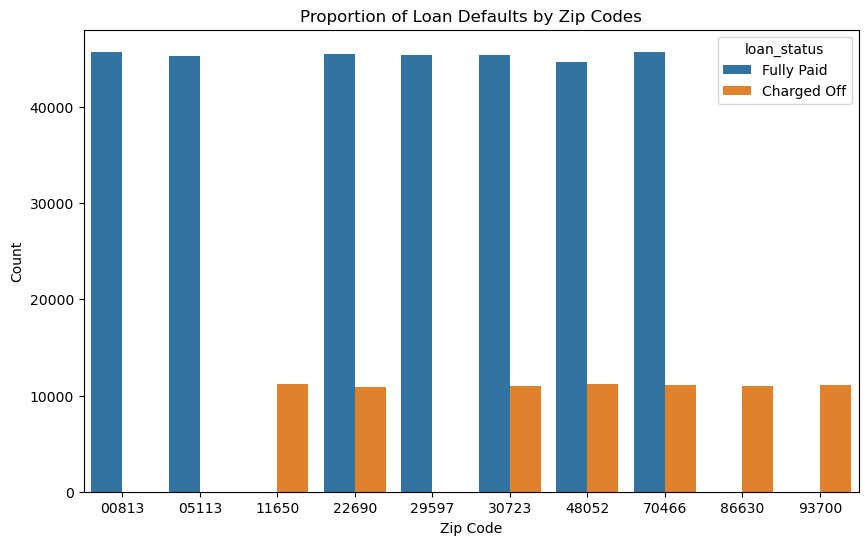

In [60]:
#sanity check
# Aggregating the data by emp_length and loan_status
grade_loan_status_counts = df.groupby(['zip_code', 'loan_status']).size().reset_index(name='counts')

# Create the bar plot

plt.figure(figsize= (10, 6))
# Plot for counts by loan status
sns.barplot(x='zip_code', y='counts', hue='loan_status', data= grade_loan_status_counts)

#labeling the axes
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.title('Proportion of Loan Defaults by Zip Codes');

**Insights**

The plot illustrates a consistent pattern where fully paid loans (blue bars) significantly outnumber charged-off loans (orange bars) across all the displayed zip codes, suggesting that, irrespective of location, most borrowers are able to repay their loans. However, certain zip codes, namely 11650, 86630, and 93700, exhibit notably higher default rates compared to zip codes 00813, 05113, and 29597, which have almost 100% repayment rates.

Upon closer inspection, the zip codes with higher default rates (11650, 86630, 93700) share common characteristics in their top five loan purposes, with loans directed towards small businesses being particularly prevalent. This aligns with our earlier EDA findings, which revealed that loans for small businesses tend to have the highest default rates, albeit with the highest average loan amounts.

In terms of geographic location, zip code 11650 is in New York, an area with a significant number of small businesses that may face stiff competition and economic pressures, contributing to higher default rates. Zip code 86630 is in Nevada, a state known for its volatile economic conditions, especially in areas reliant on tourism and entertainment industries. Zip code 93700 is in California, which has diverse economic challenges, particularly in regions with high living costs and competitive business environments.

Conversely, zip codes with the highest repayment rates (00813, 05113, 29597) show a different trend in their top five loan purposes, predominantly including loans for major purchases and home improvements. These zip codes are located in areas like Puerto Rico (00813), Vermont (05113), and South Carolina (29597). These regions might have more stable economic conditions and lower cost of living, which could contribute to borrowers' ability to repay their loans. Additionally, loans for major purchases and home improvements are typically associated with higher repayment rates, contributing to the overall lower default rates in these zip codes.

In [61]:
#dropping the address column
df.drop(columns= 'address', inplace= True)

**`earliest_cr_line`**

The feature represents the month the borrower's earliest reported credit line was opened


In [62]:
#previwing the first records
df['earliest_cr_line'].head(10)

0   1990-06-01
1   2004-07-01
2   2007-08-01
3   2006-09-01
4   1999-03-01
5   2005-01-01
6   2005-08-01
7   1994-09-01
8   1994-06-01
9   1997-12-01
Name: earliest_cr_line, dtype: datetime64[ns]

In [63]:
#extracting year of earliest credit line
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: x.year)

### Handling the Outliers

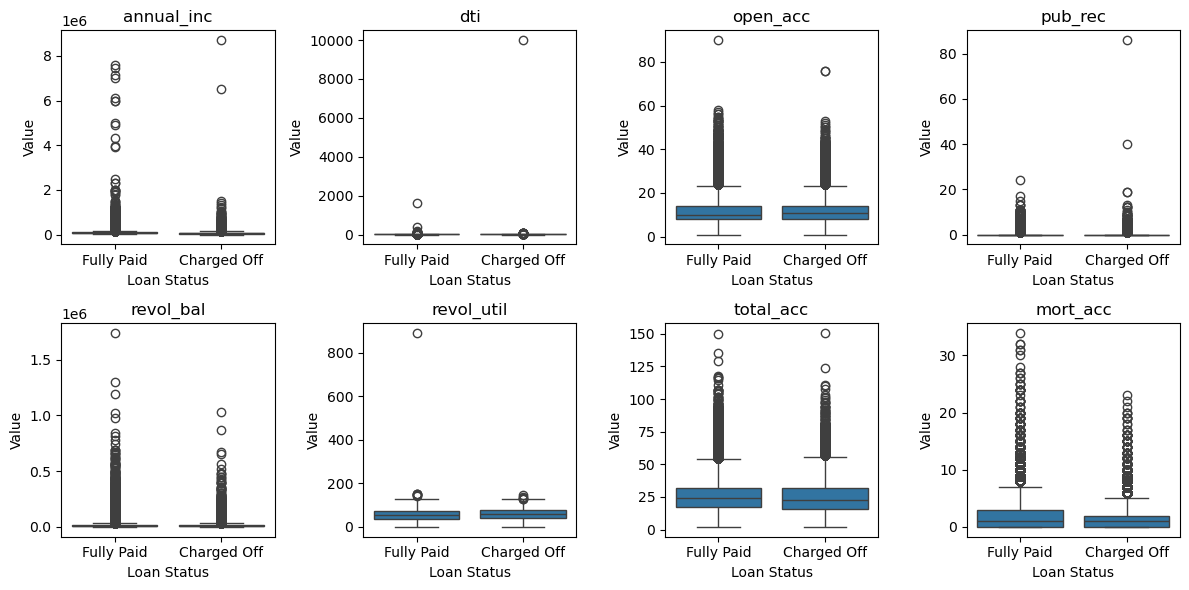

In [64]:
#checking the distribution of the outliers across the target variable

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12, 6))

#identifying columns that had extreme number of outliers
cols = ['annual_inc', 'dti','open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc']

for i, col in enumerate(cols):
    ax = axs[i // 4, i % 4]
    sns.boxplot(y = df[col], x = df['loan_status'], ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Loan Status')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

**`annual_inc`**

The decision to cap annual_inc between the 10th and 90th percentiles is justified by the observation that the distribution of outliers in annual income does not significantly differ between borrowers who fully paid their loans and those who defaulted. 

This indicates that extreme values in annual income do not provide substantial discriminatory power for predicting loan defaults.

By capping at these percentiles, we mitigate the influence of extreme outliers, reducing noise and potential skew in the data, while preserving the meaningful central range of the income distribution that is more representative of typical borrowers.

**`dti`**

The decision to cap dti (debt-to-income ratio) between the 10th and 90th percentiles is supported by the plot, which shows that extreme dti values are similarly distributed between the fully paid and charged-off loan statuses. 

These outliers do not provide additional insight into the likelihood of default but can disproportionately influence the model's training and predictions

This applies to also `open_acc`, `revol_bal`, `total_acc`, `mort_acc`, `pub_rec`.

**`'revol_util' (Revolving Line Utilization Rate)`**

Utilization rates above 100% are generally not feasible, as they suggest borrowing beyond the credit limit. Clipping values at 100% ensures that the data remains realistic and interpretable, preventing distortion of the feature distribution.




In [65]:
#calculating quantiles
low_inc, high_inc= df['annual_inc'].quantile([0.1, 0.9])
low_dti, high_dti = df['dti'].quantile([0.1, 0.9])
low_openacc, high_openacc = df['open_acc'].quantile([0.1, 0.9])
low_rec, high_rec = df['pub_rec'].quantile([0.1, 0.9])
low_bal, high_bal = df['revol_bal'].quantile([0.1, 0.9])
low_totacc, high_toacc = df['total_acc'].quantile([0.1, 0.9])
low_motacc, high_motacc = df['mort_acc'].quantile([0.1, 0.9])
low_util, high_util = df['revol_util'].quantile([0.1, 0.9])

#creating bolean masks for the features
mask_inc = df['annual_inc'].between(low_inc, high_inc)
mask_dti = df['dti'].between(low_dti, high_dti)
mask_openacc = df['open_acc'].between(low_openacc, high_openacc)
mask_rec = df['pub_rec'].between(low_rec, high_rec)
mask_bal = df['revol_bal'].between(low_bal, high_bal)
mask_totacc = df['total_acc'].between(low_totacc, high_toacc)
mask_motacc = df['mort_acc'].between(low_motacc, high_motacc)
mask_util = df['revol_util'].between(low_util, high_util)

df = df[mask_inc & mask_dti & mask_openacc & mask_rec & mask_bal & mask_totacc & mask_util & mask_motacc]

## DATA PREPROCESSING

In [66]:
#encoding the target column

df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

In [67]:
df.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code
1,8000,36 months,11.99,B,B5,others,4 years,MORTGAGE,65000.00,Not Verified,0,debt_consolidation,22.05,2004,17,0,20131,53.30,27,f,INDIVIDUAL,3.00,0.00,05113
7,13000,36 months,11.14,B,B2,others,10+ years,RENT,46000.00,Not Verified,0,credit_card,26.87,1994,11,0,13425,64.50,15,f,INDIVIDUAL,0.00,0.00,30723
8,18900,60 months,10.99,B,B3,others,10+ years,RENT,103000.00,Verified,0,debt_consolidation,12.52,1994,13,0,18637,32.90,40,w,INDIVIDUAL,3.00,0.00,22690
9,26300,36 months,16.29,C,C5,others,3 years,MORTGAGE,115000.00,Verified,0,debt_consolidation,23.69,1997,13,0,22171,82.40,37,f,INDIVIDUAL,1.00,0.00,00813
12,7500,36 months,9.17,B,B2,others,7 years,OWN,55000.00,Not Verified,0,debt_consolidation,28.21,1995,13,0,17838,54.90,35,w,JOINT,4.00,0.00,70466


In [68]:
#gauging the impact of droping emp_title to model
#df.drop(columns  = 'emp_title', inplace = True)

In [69]:
#gauging the impact of droping emp_title to model
#df.drop(columns = 'emp_length',inplace =True)

In [70]:
#defining the target

target= 'loan_status'

y = df[target]

X = df.drop(columns= target)

In [71]:
X.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code
1,8000,36 months,11.99,B,B5,others,4 years,MORTGAGE,65000.00,Not Verified,debt_consolidation,22.05,2004,17,0,20131,53.30,27,f,INDIVIDUAL,3.00,0.00,05113
7,13000,36 months,11.14,B,B2,others,10+ years,RENT,46000.00,Not Verified,credit_card,26.87,1994,11,0,13425,64.50,15,f,INDIVIDUAL,0.00,0.00,30723
8,18900,60 months,10.99,B,B3,others,10+ years,RENT,103000.00,Verified,debt_consolidation,12.52,1994,13,0,18637,32.90,40,w,INDIVIDUAL,3.00,0.00,22690
9,26300,36 months,16.29,C,C5,others,3 years,MORTGAGE,115000.00,Verified,debt_consolidation,23.69,1997,13,0,22171,82.40,37,f,INDIVIDUAL,1.00,0.00,00813
12,7500,36 months,9.17,B,B2,others,7 years,OWN,55000.00,Not Verified,debt_consolidation,28.21,1995,13,0,17838,54.90,35,w,JOINT,4.00,0.00,70466


In [72]:
#spiliting the data into training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

**Dealing with Class Imbalance**

In [73]:
#checking the distribution of the target variable
y_train.value_counts(normalize= True)

loan_status
0   0.81
1   0.19
Name: proportion, dtype: float64

Given the substantial class imbalance, with the negative class representing 81% of the data, I will employ Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTENC) to address the issue.

SMOTE works by first selecting a minority class instance `a` at random and finds its `k` nearest minority class neighbors. The synthetic instance is then created by choosing one of the `k` nearest neighbors `b` at random and connecting `a` and `b` to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances `a` and `b`. The process is then repeated until the desired between classes is achieved.

The approach is effective because new synthetic examples from the minority class are created that are plausible, that is, are relatively close in feature space to existing examples from the minority class.


In [74]:
categorical_indices = [X.columns.get_loc(col) for col in X.select_dtypes(include='object').columns]

smote = SMOTENC(categorical_features= categorical_indices, random_state= 42, sampling_strategy= 'auto', n_jobs= -1)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

c:\Users\KennedyOdhiambo\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\KennedyOdhiambo\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\KennedyOdhiambo\anaconda3\envs\learn-env\lib\site-packages\imblearn\over_sampling\_smote\base.py:645: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [121]:
y_train_resampled.value_counts(normalize= True)

loan_status
0   0.50
1   0.50
Name: proportion, dtype: float64

## MODELLING

### Baseline Model

In this project, a naive model that always predicts a borrower will default on their loan would achieve an 80% accuracy score.

While this accuracy might initially appear impressive, it fails to meet the core objective of the project: **identifying potential defaulters to mitigate financial risk for the company**. The primary goal is not merely to have a high accuracy but to accurately detect as many loan defaulters as possible to reduce financial liabilities.

Given this objective, accuracy alone is not a suitable metric for evaluating model performance. Instead, we should prioritize Recall score. Recall is crucial because it measures the proportion of actual defaulters correctly identified by the model, ensuring that we capture as many defaulters as possible. 



In [75]:
#defininhg function to evalute  the model

def evaluate_model(estimator, X, y, set_name):

    #print classification report name
    print(f'Classification Report for {set_name} Set')
    
    #predicts from estimators
    predictions = estimator.predict(X) 
    #Print recall score
    print(f'Recall Score: {round(recall_score(y, predictions), 2)}')
    #print roc_auc score
    print(f'ROC AUC Score: {round(roc_auc_score(y, predictions), 2)}')

    

    fig, ax = plt.subplots(figsize=(6,6))
    ConfusionMatrixDisplay.from_estimator(estimator, X, y, ax=ax, colorbar=False, cmap= 'Blues');


### MODEL 1: DECISION TREE CLASSIFIER

In [76]:
#building decision tree with default paramenters
dt_model = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    DecisionTreeClassifier(random_state=42)
)

#fitting the pipeline to our resampled data.
dt_model.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

Classification Report for Training Set
Recall Score: 1.0
ROC AUC Score: 1.0


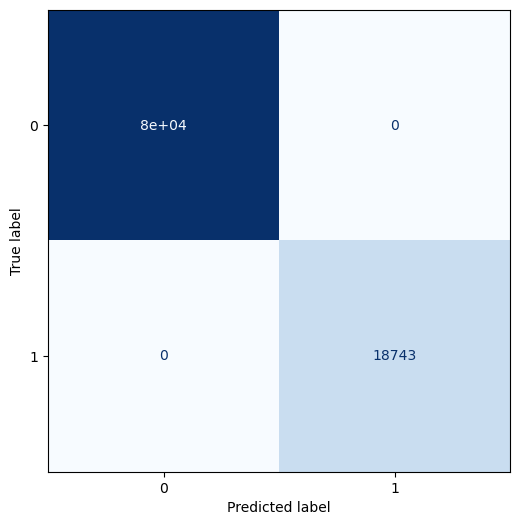

In [77]:
#evaluating the performance of the model on Training set
evaluate_model(dt_model, X_train, y_train, 'Training')

Classification Report for Test Set
Recall Score: 0.62
ROC AUC Score: 0.74


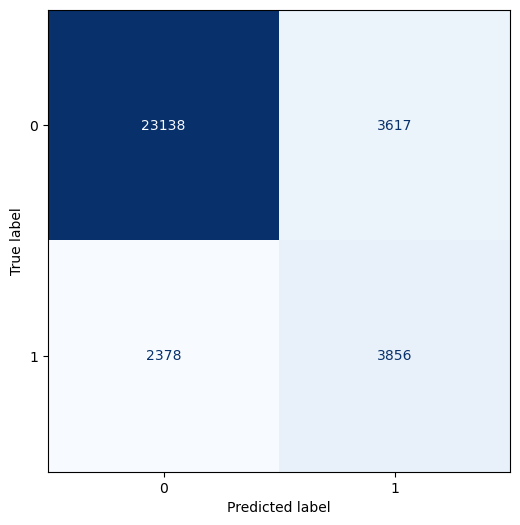

In [78]:
#evaluating the model's performance on Test se
evaluate_model(dt_model, X_test, y_test, 'Test')

The model performed exceptionally well on the traning set identifying all the defaulters. However, when evaluated on the test set, its performance dropped significantly, managing to identify only 62% of the defaulters.

This discrepancy indicates that the model is overfitting; it has learned the nuances and noise in the training data too well, resulting in excellent training performance but poor generalization to new, unseen data. 

As a result, the model's ability to accurately predict defaulters in the test set is compromised, highlighting the need for strategies to improve generalization.

### MODEL 2: GRIDSEARCHCV WITH RANDOM FOREST

In [79]:
params = {
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': range(10, 50, 10),
    'randomforestclassifier__n_estimators': range(25, 100, 25)
}

rf_model  = make_pipeline(

    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),

    RandomForestClassifier(random_state= 42)
)

gs_model = GridSearchCV(
    
    estimator= rf_model, param_grid= params, verbose= 1, 
    cv = 5, n_jobs= -1                    

)

gs_model.fit(X_train_resampled, y_train_resampled)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(handle_unknown='use_encoded_value',
                                                       unknown_value=-1)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

In [80]:
#Checking the best parameters from the gridsearch

gs_model.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30, n_estimators=75,
                                        random_state=42))])

Classification Report for Training Set
Recall Score: 0.99
ROC AUC Score: 0.99


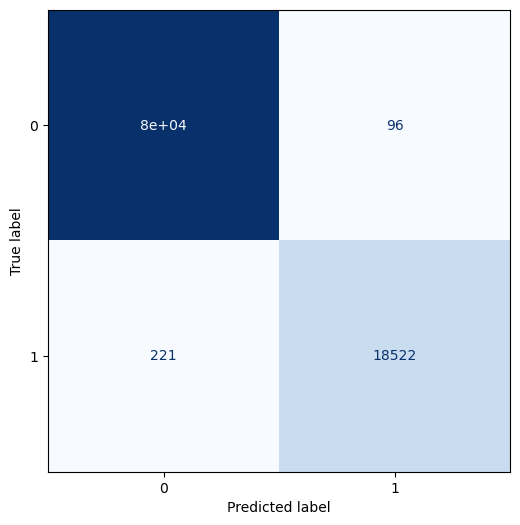

In [81]:
evaluate_model(estimator= gs_model, X = X_train, y = y_train,set_name= 'Training')

Classification Report for Test Set
Recall Score: 0.54
ROC AUC Score: 0.75


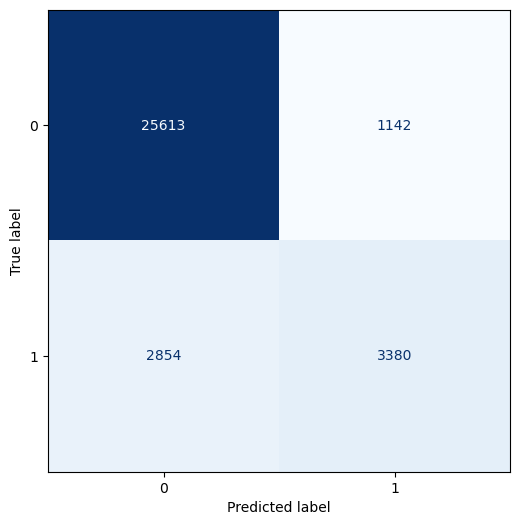

In [82]:
#evaluating the best model on the training set
evaluate_model(estimator= gs_model, X = X_test, y = y_test, set_name= 'Test')

The best estimator from our grid search is performing exceptionally well on the training data, identifying 99% of default borrowers. 

However, it performs poorly on the test set, capturing only 55% of the defaulters.

This stark contrast indicates that the model is overfitting: it has learned the training data too well, including its noise and unique patterns, which do not generalize to new, unseen data. 

Consequently, while the model appears highly effective during training, its real-world predictive power is significantly compromised, necessitating further adjustments to improve its generalizability and reliability in identifying defaulters.

### MODEL 3: TUNING TREE DEPTH, DECISION TREE 

In [83]:
#testing depth between 1 and 50 with step of 2

depth_hyperparams = range(1, 50, 2)

# Creating empty lists for training and test Recall scores
training_recall = []
test_recall= []

for d in depth_hyperparams:
    
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        DecisionTreeClassifier(max_depth= d, random_state= 42)
    )
    
    # Fit model to training data
    test_model.fit(X_train_resampled, y_train_resampled)
    
    # Calculate training recall score and append to `training_acc`
    training_recall.append(recall_score(y_train, test_model.predict(X_train)))
    
    # Calculate test set recall score and append to `training_acc`
    test_recall.append(recall_score(y_test, test_model.predict(X_test)))

print("Training RECALL Scores:", training_recall[:3])
print("Validation RECALL Scores:", test_recall[:3])

Training RECALL Scores: [1.0, 0.42789308008323107, 0.8266019313877181]
Validation RECALL Scores: [1.0, 0.4332691690728264, 0.8298042990054539]


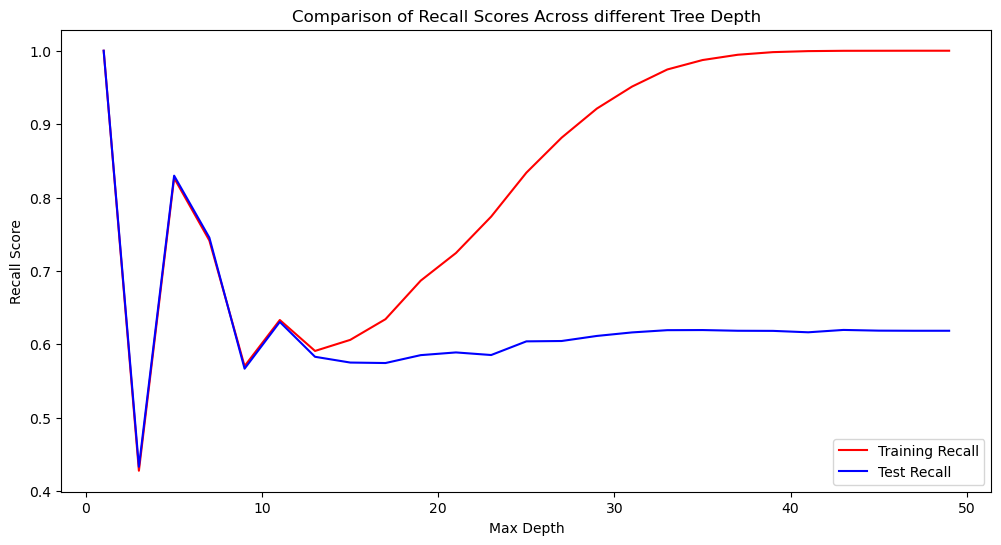

In [84]:
# Plot `depth_hyperparams`, `training_acc`
fig, ax = plt.subplots(figsize = (12, 6))

ax.plot(depth_hyperparams, training_recall, color = 'r', label = 'Training Recall')
ax.plot(depth_hyperparams, test_recall, color = 'b', label = 'Test Recall')

ax.set_xlabel('Max Depth')
ax.set_ylabel('Recall Score')
ax.set_title('Comparison of Recall Scores Across different Tree Depth')

plt.legend();


### Minimum viable product

For this project, our goal is to develop a robust model that effectively identifies loan defaulters. After extensive evaluation, we found that the decision tree model with a `max_depth` of 7 emerged as our minimum viable product (MVP).

This model struck the optimal balance between complexity and performance, enabling it to capture the essential patterns needed to detect defaulters without overfitting the training data. 

By constraining the tree's depth, we ensure that the model remains interpretable and generalizes well to new, unseen data, providing a reliable foundation for making informed lending decisions.

In [85]:
#buliding the deceision tree with optimal parameters
mvp_model = make_pipeline(
    
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    
    DecisionTreeClassifier(max_depth = 7, random_state=42)

)

#fitting the pipeline to our resampled data.
mvp_model.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=7, random_state=42))])

### MODEL EVALUATION

Classification Report for Test Set
Recall Score: 0.75
ROC AUC Score: 0.77


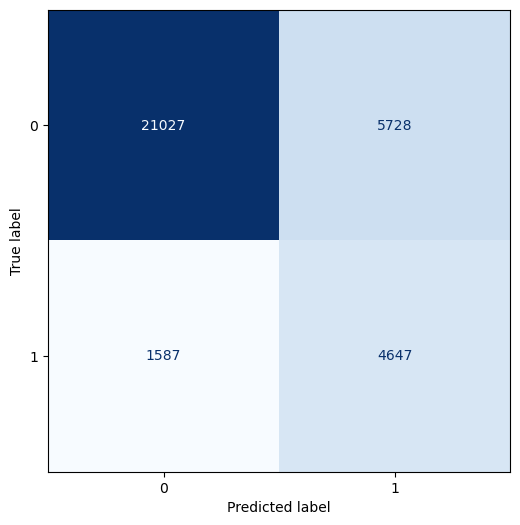

In [86]:
#confirming the performance on the Test set

evaluate_model(mvp_model, X_test, y_test, 'Test')

**Interpretation**

In the context of this project, a false positive occurs when the model predicts that a customer would default on the loan, but they end up repaying it. The consequence of this is the potential loss of business and customer dissatisfaction, as creditworthy applicants may be denied loans or offered less favorable terms unnecessarily.

Conversely, a false negative occurs when the model predicts that a customer would repay the loan, but they end up defaulting. This has a significant financial impact on the company as it leads to direct financial losses from unpaid loans and increased costs related to debt collection and management.

Given the context, false negatives are more detrimental to the company's financial feasibility compared to false positives. This is because the financial losses from defaults are more substantial and harder to recover from than the opportunity costs associated with false positives.

Regarding model performance, our MVP model attained a recall of 75% on unseen data, meaning it successfully identified at least 75% of all defaulters. Additionally, the model correctly classified defaulters 77% of the time, indicating strong performance in distinguishing high-risk applicants from low-risk ones.


In [87]:
features = X_train.columns.to_list()
importances = mvp_model.named_steps['decisiontreeclassifier'].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: ['loan_amnt', 'term', 'int_rate']
Importances: [0.         0.01668032 0.12547154]


In [88]:
feat_imp = pd.Series(importances, index= features).sort_values()
feat_imp.tail()

term        0.02
grade       0.02
int_rate    0.13
sub_grade   0.15
zip_code    0.68
dtype: float64

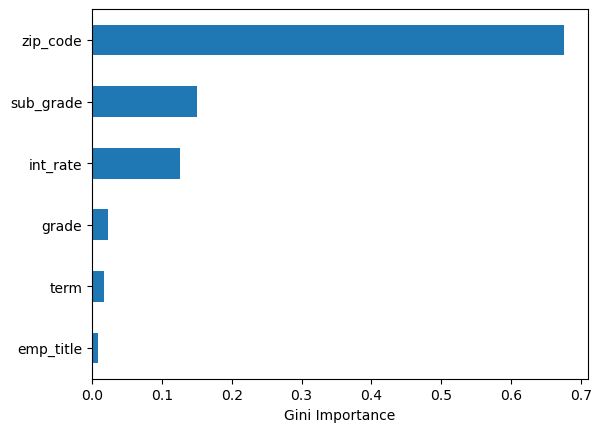

In [89]:

feat_imp.tail(6).plot(kind = 'barh')

plt.xlabel('Gini Importance');

**Interpretation**

- **`term (0.02)`**: The loan term (length of the loan) has a very low importance score of 0.02. This suggests that the length of the loan (e.g., 36 months vs. 60 months) has minimal impact on the model's decision-making process. It indicates that the term of the loan is not a significant factor in predicting the target variable, possibly because the risk associated with different loan terms is already factored into other more influential variables like interest rate or sub-grade.
  
- **`grade (0.02)`**: The overall loan grade also has a very low importance score of 0.02, indicating that it contributes minimally to the model's predictions. This may be because the sub-grade, which provides a more detailed risk assessment within each grade, is more informative and thus takes precedence over the broader grade category.
  
- **`int_rate (0.13)`**: The interest rate has a moderate importance score of 0.13. This suggests that the interest rate is a moderately significant factor in the model's decision-making process. Since interest rates are directly correlated with the borrower's credit risk, this importance score makes sense, as higher interest rates are typically associated with higher-risk loans.
  
- **`sub_grade (0.15)`**: The sub-grade, with an importance score of 0.15, is slightly more important than the interest rate. This indicates that the sub-grade, which offers a more granular assessment of the borrower's credit risk within each grade, plays a slightly more significant role in predicting the target variable. The sub-grade provides more specific information on the risk level, which enhances the model's accuracy.
  
- **`zip_code (0.68)`**: The zip code has the highest importance score of 0.68, making it the most influential feature in the decision tree model. This aligns with our EDA findings, where certain zip codes like 93700 and 11650 had significantly higher default rates compared to zip code 00813, which had nearly 100% repayment rates. This high importance suggests that the geographic location of the borrower, as indicated by the zip code, is a critical factor in predicting loan outcomes. The zip code likely serves as a proxy for various socio-economic factors such as regional economic conditions, employment rates, and local cost of living, all of which can significantly influence a borrower's ability to repay a loan.


## Conclusions

- There is a significant difference in interest rates charged across different loan grades. High-risk borrowers (grade G) are charged higher interest rates (approximately 25%), whereas low-risk borrowers (grade A) are charged lower interest rates (approximately 7.5%). This aligns with the higher proportion of defaults observed in grade G, highlighting the need for differentiated interest rates to mitigate risk.

- Zip codes play a crucial role in predicting loan defaults. Certain zip codes, such as 93700 and 11650, have significantly higher default rates compared to others like 00813. This suggests that regional socio-economic factors greatly influence loan repayment behaviors. Incorporating geographic information into the risk assessment process is essential for accurate predictions.

## Business Recommendations

1. **Support for Small Business Borrowers**:
    - Given the higher default rates among small business loans, the lending company should provide additional support and resources for small business borrowers. This could include financial planning assistance, business mentoring, and periodic financial monitoring to help these borrowers succeed and repay their loans.

2. **Geographic-Based Strategies**:
    - Implement targeted lending strategies based on geographic locations. Consider local economic conditions and historical default rates when making lending decisions. This could involve different approval criteria, interest rates, and loan terms tailored to specific regions to better manage risk.

4. **Risk-Based Interest Rates**:
    - Continue using differentiated interest rates for various loan grades to compensate for the associated risks. High-risk borrowers should be charged higher rates to mitigate potential losses, while low-risk borrowers can be offered more competitive rates to attract quality applicants.

5. Regular update and refine the model with new data to maintain its accuracy and relevance, adapting to changing economic conditions and borrower behaviors.


## Deployment

To deploy the model, I created an app using Flask and deployed it on render where you can key in customer information then click on `PREDICT` button then the app will give you the predicted loan status.

The app can be found at [Loan Default Detection App](https://loan-default-prediction-l8mf.onrender.com/)

You can also send POST requests with customer information, to the `/predict` endpoint and the API responds with the predicted loan status of the customer. You can also access the api documentation on the `/api-documnetation` endpoint.


On the README accompanied with this notebook I have documented the format to send the requests. 


**Challenges in a Real-Time Environment and Their Solutions**
- As new data becomes available, the model may need to be retrained and redeployed. I would implement a CI/CD pipeline to automate the deployment process, allowing for seamless updates without downtime.
  
- **Latency**: Real-time predictions need to be fast. Optimize the model and use efficient data processing techniques to reduce latency. Implement caching mechanisms for frequently requested data.

**Monitoring Model Performance Post-Deployment**
- Collect feedback on the model’s predictions and use it to improve the model. For instance, track the actual loan repayment behavior of customers and compare it to the model’s predictions.
  
-  Schedule regular retraining of the model with new data to ensure it remains up-to-date and accurate. Automate the retraining process to minimize manual intervention.


In [90]:
#saving the model

#with open('model.pkl', 'wb') as f:
 #   joblib.dump(mvp_model, f)

In [132]:
#Testing the depoloyed API
import requests
response = requests.post(
    url="https://loan-default-prediction-l8mf.onrender.com/predict",
    
    json={
        "loan_amnt": 20000,
        "term": '18 months',
        "int_rate": 20.8,
        "grade": 'C',
        "sub_grade":'C5',
        "emp_title": 'teacher',
        "emp_length": '4 years',
        "home_ownership": 'MORTGAGE',
        "annual_inc": 10000,
        "verification_status": 'Not Verified',
        "purpose": 'small_business',
        "dti": 30.05,
        "earliest_cr_line": 2008,
        "open_acc": 10,
        "pub_rec": 0,
        "revol_bal": 20200,
        "revol_util": 73.01,
        "total_acc": 37,
        "initial_list_status": 'f',
        "application_type": 'INDIVIDUAL',
        "mort_acc": 5,
        "pub_rec_bankruptcies": 2,
        "zip_code": '11650'   
    }
)
response

<Response [200]>

In [133]:
#Extrating the predicted loan status
response.json()

{'prediction': 1}

$$**END**$$